In [1]:
pip install pandas numpy matplotlib seaborn scipy statsmodels scikit-learn

Note: you may need to restart the kernel to use updated packages.


Processing sheets (readers):
- Processing sheet: hana_lee
- Processing sheet: yoojin_nam
- Processing sheet: jeongmin_song
- Processing sheet: jimin_kwon
- Processing sheet: jeongmin_lee
- Processing sheet: dong_yeong_kim
- Processing sheet: ahyoung_jung
- Processing sheet: hyungi_kim
- Processing sheet: hyunjoo_shin
- Processing sheet: jisun_hwang
- Processing sheet: jeongrye_kim
- Processing sheet: haesung_yoon
- Processing sheet: patrick_lenehan
- Processing sheet: jinwha choi

--- Checking for Duplicate Reads ---
No duplicate reads found.

--- Final Data Checks ---
Successfully processed data for 14 readers.
*** Warning: Expected 15 readers, but processed data for 14. ***
Unique Reader IDs: ['hana_lee' 'yoojin_nam' 'jeongmin_song' 'jimin_kwon' 'jeongmin_lee'
 'dong_yeong_kim' 'ahyoung_jung' 'hyungi_kim' 'hyunjoo_shin' 'jisun_hwang'
 'jeongrye_kim' 'haesung_yoon' 'patrick_lenehan' 'jinwha choi']
Unique Experience Levels: ['Specialist' 'Resident']
Unique Conditions: ['OptimizedAI', '

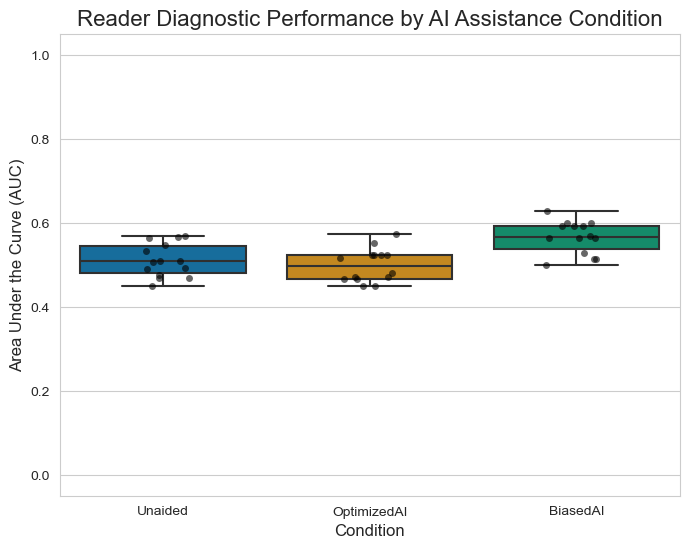


--- Secondary Analyses ---

--- Reading Time Analysis (Wilcoxon) ---
Reading Time (OptimizedAI vs. Unaided): N=14, Stat=6.000, p=0.0017
Reading Time (BiasedAI vs. Unaided): N=14, Stat=11.000, p=0.0067

--- CAM Click Analysis ---
CAM Click Percentage:
condition
Unaided          NaN
OptimizedAI    17.50
BiasedAI       14.12
Name: cam_clicked, dtype: float64

--- Analysis pipeline complete. Review outputs carefully. ---


In [11]:
# --- Part 0: Setup ---
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wilcoxon
from statsmodels.stats.contingency_tables import mcnemar
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.genmod.generalized_estimating_equations import GEE
from statsmodels.genmod.cov_struct import Exchangeable # Common correlation structure
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, confusion_matrix
import warnings # To manage convergence warnings

# --- Part 1: Data Loading and Preprocessing ---

# --- Configuration ---
file_path = "/Users/junlee/Desktop/nec_lat_result.xlsx" # <<< Your exact file path
header_row_index = 6 # Row 7 is the header (0-based index)

# --- Check if file exists ---
if not os.path.exists(file_path):
    raise FileNotFoundError(f"Error: The file was not found at {file_path}")

# --- Load the Excel file ---
xls = pd.ExcelFile(file_path)

# --- Process each sheet (each reader) ---
all_reader_data = []
print("Processing sheets (readers):")
processed_sheets = []
skipped_sheets = []
expected_rows_per_reader = 125 # Define expected count

for sheet_name in xls.sheet_names:
    print(f"- Processing sheet: {sheet_name}")
    try:
        # --- Metadata Extraction ---
        df_meta_part = pd.read_excel(xls, sheet_name=sheet_name, header=None, nrows=5)
        reader_id = "Unknown_ID"; reader_experience = "Unknown" # Defaults
        try:
            reader_id_str = str(df_meta_part.iloc[0, 0]).strip()
            reader_id = reader_id_str.split(':', 1)[1].strip() if ':' in reader_id_str else reader_id_str
            if not reader_id: reader_id = f"Reader_{sheet_name}"

            reader_title_str = str(df_meta_part.iloc[2, 0]).strip()
            reader_title = (reader_title_str.split(':', 1)[1].strip().lower() if ':' in reader_title_str else reader_title_str.lower())

            if 'specialist' in reader_title: reader_experience = 'Specialist'
            elif 'resident' in reader_title: reader_experience = 'Resident'
            else: print(f"  Warning: Unknown title '{reader_title}' in sheet {sheet_name}. Defaulting to 'Unknown'.")
        except Exception as e:
            print(f"  Error parsing metadata in sheet {sheet_name}: {e}. Skipping sheet.")
            skipped_sheets.append(sheet_name)
            continue

        # --- Read Main Data ---
        df_sheet = pd.read_excel(xls, sheet_name=sheet_name, header=header_row_index)
        df_sheet.columns = df_sheet.columns.str.strip().str.lower().str.replace(' ', '_')

        # --- Check for expected columns ---
        # Add 'optimized' and 'debuffed' if they exist and might be needed later (though not used in core analysis)
        essential_raw_cols = ['filename', 'answer', 'show_cam', 'time', 'groundtruthbinary', 'with_ai', 'ai_model']
        optional_ai_cols = ['optimized', 'debuffed'] # Check if these exist
        
        actual_cols = df_sheet.columns
        missing_essential = [col for col in essential_raw_cols if col not in actual_cols]
        if missing_essential:
            print(f"  Warning: Missing essential data columns in sheet {sheet_name}: {missing_essential}. Skipping sheet.")
            skipped_sheets.append(sheet_name)
            continue
            
        # Rename essential columns
        rename_map = {
            'filename': 'case_id', 'answer': 'reader_prediction_raw', 'show_cam': 'cam_clicked',
            'time': 'reading_time', 'groundtruthbinary': 'ground_truth_raw', 'with_ai': 'with_ai',
            'ai_model': 'ai_model_raw'
        }
        # Include optional AI columns in rename map if they exist
        for col in optional_ai_cols:
            if col in actual_cols:
                rename_map[col] = f'{col}_ai_pred' # Rename to avoid confusion with reader pred

        df_sheet = df_sheet.rename(columns=rename_map)

        # --- Data Cleaning & Transformation ---
        required_cols_to_process = list(rename_map.values()) # Process all renamed cols
        df_sheet = df_sheet[required_cols_to_process].copy()

        # Ground Truth Cleaning
        df_sheet['ground_truth'] = pd.to_numeric(df_sheet['ground_truth_raw'], errors='coerce')
        invalid_gt_count = df_sheet['ground_truth'].isnull().sum()
        if invalid_gt_count > 0:
            print(f"  Warning: Found {invalid_gt_count} non-numeric/missing ground truth values in sheet {sheet_name}. These rows will be dropped.")
            df_sheet.dropna(subset=['ground_truth'], inplace=True)
        if df_sheet.empty:
             print(f"  Sheet {sheet_name} empty after dropping invalid ground truth. Skipping.")
             skipped_sheets.append(sheet_name)
             continue
        df_sheet['ground_truth'] = df_sheet['ground_truth'].astype(int)

        # Reader Prediction
        df_sheet['reader_prediction'] = df_sheet['reader_prediction_raw'].apply(lambda x: 1 if str(x).strip().upper() == 'Y' else 0)

        # Condition Determination
        def determine_condition(row):
            ai_model = str(row['ai_model_raw']).strip() if pd.notna(row['ai_model_raw']) else ''
            ai_status = pd.to_numeric(row['with_ai'], errors='coerce')
            if ai_status == 0: return 'Unaided'
            elif ai_status == 1:
                if ai_model == 'OptimizedAI': return 'OptimizedAI'
                elif ai_model == 'DebuffedAI': return 'BiasedAI'
                else: return pd.NA # Ambiguous if with_ai=1 but model is missing/invalid
            else: return pd.NA # Ambiguous if with_ai is missing/invalid

        df_sheet['condition'] = df_sheet.apply(determine_condition, axis=1)

        # Drop rows with ambiguous conditions
        unknown_condition_count = df_sheet['condition'].isnull().sum()
        if unknown_condition_count > 0:
            print(f"  Warning: Found {unknown_condition_count} rows with ambiguous AI conditions in sheet {sheet_name}. Dropping.")
            df_sheet.dropna(subset=['condition'], inplace=True)
        if df_sheet.empty:
             print(f"  Sheet {sheet_name} empty after dropping ambiguous conditions. Skipping.")
             skipped_sheets.append(sheet_name)
             continue

        # CAM Clicked Processing
        df_sheet['cam_clicked'] = df_sheet['cam_clicked'].fillna(0)
        df_sheet['cam_clicked'] = df_sheet.apply(lambda row: 0 if row['condition'] == 'Unaided' else row['cam_clicked'], axis=1)
        df_sheet['cam_clicked'] = pd.to_numeric(df_sheet['cam_clicked'], errors='coerce').fillna(0).astype(int)

        # Add Metadata
        df_sheet['reader_id'] = reader_id
        df_sheet['reader_experience'] = reader_experience

        # Final Column Selection
        final_cols = ['reader_id', 'reader_experience', 'case_id', 'ground_truth',
                      'condition', 'reader_prediction', 'reading_time', 'cam_clicked']
        # Also include AI prediction columns if they were present
        if 'optimized_ai_pred' in df_sheet.columns: final_cols.append('optimized_ai_pred')
        if 'debuffed_ai_pred' in df_sheet.columns: final_cols.append('debuffed_ai_pred')

        df_sheet = df_sheet[final_cols]

        # Check expected row count for this reader
        if len(df_sheet) != expected_rows_per_reader:
             print(f"  Warning: Sheet {sheet_name} has {len(df_sheet)} rows after cleaning, expected {expected_rows_per_reader}.")

        all_reader_data.append(df_sheet)
        processed_sheets.append(sheet_name)

    except Exception as e:
        print(f"  General Error processing sheet {sheet_name}: {e}. Skipping sheet.")
        skipped_sheets.append(sheet_name)

# --- Combine all sheets ---
if not all_reader_data:
     raise ValueError("No data successfully processed. Check file path, format, and warnings.")
df_long = pd.concat(all_reader_data, ignore_index=True)

# --- Remove Duplicates ---
print("\n--- Checking for Duplicate Reads ---")
duplicates = df_long.duplicated(subset=['reader_id', 'case_id', 'condition'], keep=False)
n_duplicates = duplicates.sum()
if n_duplicates > 0:
    print(f"*** Warning: Found {n_duplicates} duplicate entries. Examples: ***")
    print(df_long[duplicates].sort_values(['reader_id', 'case_id', 'condition']).head())
    df_long = df_long.drop_duplicates(subset=['reader_id', 'case_id', 'condition'], keep='first')
    print(f"Dropped duplicates. New total observations: {len(df_long)}")
else: print("No duplicate reads found.")

# --- Final Data Prep ---
df_long['is_correct'] = (df_long['ground_truth'] == df_long['reader_prediction']).astype(int)
condition_order = ['Unaided', 'OptimizedAI', 'BiasedAI']
# Check if all conditions exist before setting category
existing_conditions = [c for c in condition_order if c in df_long['condition'].unique()]
df_long['condition'] = pd.Categorical(df_long['condition'], categories=existing_conditions, ordered=True)
df_long.dropna(subset=['condition'], inplace=True) # Drop any rows that still have NA condition

# --- Final Checks ---
print("\n--- Final Data Checks ---")
final_reader_count = df_long['reader_id'].nunique()
print(f"Successfully processed data for {final_reader_count} readers.")
if skipped_sheets: print(f"Skipped {len(skipped_sheets)} sheets due to errors: {skipped_sheets}")
if final_reader_count != 15: print(f"*** Warning: Expected 15 readers, but processed data for {final_reader_count}. ***")

print("Unique Reader IDs:", df_long['reader_id'].unique())
print("Unique Experience Levels:", df_long['reader_experience'].unique())
print("Unique Conditions:", df_long['condition'].unique())
critical_cols_check = ['reader_id', 'reader_experience', 'case_id', 'ground_truth', 'condition', 'reader_prediction', 'is_correct']
missing_data_report = df_long[critical_cols_check].isnull().sum()
print("\nMissing values check in final critical columns:")
print(missing_data_report[missing_data_report > 0])
if missing_data_report.sum() > 0: raise ValueError("Critical missing values found AFTER cleaning. Halting execution.")

expected_total_rows = final_reader_count * expected_rows_per_reader
print(f"\nTotal observations (rows) in final DataFrame: {len(df_long)} (Expected ~{expected_total_rows} before potential drops)")
if len(df_long) < expected_total_rows * 0.9: # Check if significantly fewer rows than expected
     print(f"*** Warning: Significantly fewer rows ({len(df_long)}) than expected ({expected_total_rows}). Check data quality and cleaning steps. ***")
print("DataFrame head:\n", df_long.head())
print("\nDataFrame info:")
df_long.info()


# --- Part 2: Performance Metrics Calculation (Table 2) ---

# Using the robust calculate_metrics function from previous response
def calculate_metrics(data):
    gt = data['ground_truth']
    pred = data['reader_prediction']
    labels_present = np.unique(gt)
    auc, sens, spec = np.nan, np.nan, np.nan
    tn, fp, fn, tp = 0, 0, 0, 0

    if len(labels_present) == 2:
        try: auc = roc_auc_score(gt, pred)
        except ValueError: auc = np.nan # Handle cases where only one prediction value exists
        cm = confusion_matrix(gt, pred, labels=[0, 1]).ravel(); tn, fp, fn, tp = cm
        sens = tp / (tp + fn) if (tp + fn) > 0 else 0
        spec = tn / (tn + fp) if (tn + fp) > 0 else 0
    elif 1 in labels_present: sens = recall_score(gt, pred, pos_label=1, zero_division=0)
    elif 0 in labels_present:
        cm = confusion_matrix(gt, pred, labels=[0, 1]).ravel(); tn, fp, fn, tp = cm
        spec = tn / (tn + fp) if (tn + fp) > 0 else 0

    acc = accuracy_score(gt, pred)
    return pd.Series({'AUC': auc, 'Accuracy': acc, 'Sensitivity': sens, 'Specificity': spec})

print("\n--- Calculating Performance Metrics (Table 2) ---")
# Use observed=False to include categories even if empty after cleaning
performance_results = df_long.groupby(['reader_experience', 'condition'], observed=False).apply(calculate_metrics)
all_readers_performance = df_long.groupby('condition', observed=False).apply(calculate_metrics)
all_readers_performance.index = pd.MultiIndex.from_product([['All Readers'], all_readers_performance.index.categories], names=['reader_experience', 'condition'])
final_performance_table = pd.concat([all_readers_performance, performance_results]).dropna(how='all') # Drop rows that might be all NaN if a group was empty

print("\n--- Manuscript Table 2: Performance Metrics ---")
print(final_performance_table.round(3))
final_performance_table.to_csv('manuscript_table_2_performance.csv')
print("\nPerformance table saved.")


# --- Part 3: Hypothesis Testing (Revised) ---

print("\n--- Hypothesis Testing ---")

# --- Per-Reader Metrics for Paired Tests ---
print("\n--- Calculating Per-Reader Metrics ---")
# Use the robust calculate_metrics function
per_reader_metrics = df_long.groupby(['reader_id', 'condition'], observed=False).apply(calculate_metrics)
# Handle potential missing conditions for some readers after unstacking
per_reader_auc = per_reader_metrics['AUC'].unstack(fill_value=np.nan)
per_reader_sens = per_reader_metrics['Sensitivity'].unstack(fill_value=np.nan)
per_reader_spec = per_reader_metrics['Specificity'].unstack(fill_value=np.nan)
per_reader_acc = per_reader_metrics['Accuracy'].unstack(fill_value=np.nan) # Added Accuracy

print("Per-Reader AUCs (head):\n", per_reader_auc.head().round(3))
print("Per-Reader Accuracy (head):\n", per_reader_acc.head().round(3)) # Added

# --- Wilcoxon Signed-Rank Tests (Paired Comparisons for All Metrics) ---
print("\n--- Wilcoxon Signed-Rank Tests (Paired Comparisons) ---")
def run_wilcoxon(metric_df, cond1, cond2, metric_name):
    """Helper function for paired Wilcoxon tests."""
    if cond1 not in metric_df.columns or cond2 not in metric_df.columns:
        print(f"Skipping Wilcoxon for {metric_name}: Columns '{cond1}' or '{cond2}' not found.")
        return
    paired_data = metric_df[[cond1, cond2]].dropna()
    if len(paired_data) >= 6:
        diffs = paired_data[cond2] - paired_data[cond1]
        if np.all(diffs == 0):
             print(f"{metric_name} ({cond2} vs. {cond1}): N={len(paired_data)}, No difference observed (p=1.0).")
             return
        try:
             # Use correction='auto' for continuity correction with ties/zeros
             stat, p_val = wilcoxon(paired_data[cond2], paired_data[cond1], zero_method='zsplit', correction=True)
             print(f"{metric_name} ({cond2} vs. {cond1}): N={len(paired_data)}, Stat={stat:.3f}, p={p_val:.4f}")
        except ValueError as e: print(f"Could not run Wilcoxon for {metric_name} ({cond2} vs. {cond1}): {e}")
    else: print(f"Not enough paired data ({len(paired_data)}) for {metric_name} ({cond2} vs. {cond1}) Wilcoxon test.")

# Run for all primary metrics
run_wilcoxon(per_reader_auc, 'Unaided', 'OptimizedAI', 'AUC')
run_wilcoxon(per_reader_auc, 'Unaided', 'BiasedAI', 'AUC')
run_wilcoxon(per_reader_acc, 'Unaided', 'OptimizedAI', 'Accuracy') # <<< ADDED
run_wilcoxon(per_reader_acc, 'Unaided', 'BiasedAI', 'Accuracy') # <<< ADDED
run_wilcoxon(per_reader_sens, 'Unaided', 'OptimizedAI', 'Sensitivity')
run_wilcoxon(per_reader_sens, 'Unaided', 'BiasedAI', 'Sensitivity')
run_wilcoxon(per_reader_spec, 'Unaided', 'OptimizedAI', 'Specificity')
run_wilcoxon(per_reader_spec, 'Unaided', 'BiasedAI', 'Specificity')

# --- McNemar's Tests Section REMOVED ---

# --- Hypothesis 3: GEE (Interaction Effect - Code Unchanged) ---
print("\n--- GEE for Interaction Effect (Condition * Experience) ---")
df_gee = df_long.dropna(subset=['condition', 'reader_experience', 'is_correct', 'reader_id'])
df_gee = df_gee[df_gee['reader_experience'] != 'Unknown'].copy()
# Ensure categorical types for formula
df_gee['condition'] = df_gee['condition'].astype(str)
df_gee['reader_experience'] = df_gee['reader_experience'].astype(str)
df_gee['is_correct'] = df_gee['is_correct'].astype(float)


if df_gee['reader_experience'].nunique() < 2:
    print("Warning: Only one experience level found. Interaction cannot be estimated.")
else:
    formula = "is_correct ~ C(condition, Treatment('Unaided')) * C(reader_experience, Treatment('Specialist'))"
    if not df_gee.empty:
        try:
            print("Fitting GEE model...")
            fam = sm.families.Binomial()
            cs = Exchangeable()
            # Suppress convergence warnings during fitting, check results after
            with warnings.catch_warnings():
                 warnings.simplefilter("ignore")
                 gee = smf.gee(formula, groups=df_gee["reader_id"], data=df_gee, family=fam, cov_struct=cs)
                 result_gee = gee.fit(cov_type='robust') # Use robust SEs
            print(result_gee.summary())
            # Check convergence
            if not result_gee.converged:
                print("\n*** Warning: GEE model did not converge. Results may be unreliable. Consider checking data distribution or model specification. ***")
            print("\nCheck p-value ('P>|z|') for interaction terms like 'C(condition, Treatment('BiasedAI')):C(reader_experience, Treatment('Resident'))'")

        except Exception as e_gee: print(f"Error fitting GEE: {e_gee}.")
    else: print("GEE could not be run: DataFrame is empty after cleaning.")

# --- Part 4: Plotting (Figure 3 - AUC Boxplot) ---
print("\n--- Generating Figure 3: AUC Box Plot ---")
per_reader_auc_melted = per_reader_auc.reset_index().melt(
    id_vars='reader_id', value_vars=existing_conditions, # Use only conditions present in data
    var_name='condition', value_name='AUC').dropna()

# Ensure condition is categorical with the right order for plotting
per_reader_auc_melted['condition'] = pd.Categorical(per_reader_auc_melted['condition'], categories=existing_conditions, ordered=True)

plt.figure(figsize=(8, 6)); sns.set_style("whitegrid")
ax = sns.boxplot(x='condition', y='AUC', data=per_reader_auc_melted,
                 order=existing_conditions, palette="colorblind", showfliers=False)
sns.stripplot(x='condition', y='AUC', data=per_reader_auc_melted,
              order=existing_conditions, color='black', alpha=0.6, jitter=0.15, ax=ax)
ax.set_title('Reader Diagnostic Performance by AI Assistance Condition', fontsize=16)
ax.set_xlabel('Condition', fontsize=12); ax.set_ylabel('Area Under the Curve (AUC)', fontsize=12)
ax.set_ylim(-0.05, 1.05)
plt.savefig('manuscript_figure_3_auc_boxplot.png', dpi=300, bbox_inches='tight')
plt.savefig('manuscript_figure_3_auc_boxplot.pdf', bbox_inches='tight')
print("Box plot saved.")
plt.show()

# --- Part 5: Secondary Analyses ---
print("\n--- Secondary Analyses ---")
print("\n--- Reading Time Analysis (Wilcoxon) ---")
per_reader_time = df_long.groupby(['reader_id', 'condition'], observed=False)['reading_time'].mean().unstack(fill_value=np.nan)
run_wilcoxon(per_reader_time, 'Unaided', 'OptimizedAI', 'Reading Time')
run_wilcoxon(per_reader_time, 'Unaided', 'BiasedAI', 'Reading Time')

print("\n--- CAM Click Analysis ---")
cam_clicks = df_long[df_long['condition'].isin(['OptimizedAI', 'BiasedAI'])]
if not cam_clicks.empty and 'condition' in cam_clicks.columns:
    click_percentage = cam_clicks.groupby('condition', observed=False)['cam_clicked'].mean() * 100
    print("CAM Click Percentage:")
    print(click_percentage.round(2))
else: print("No data for CAM click analysis.")

print("\n--- Analysis pipeline complete. Review outputs carefully. ---")

Processing sheets (readers):
- Processing sheet: hana_lee
- Processing sheet: yoojin_nam
- Processing sheet: jeongmin_song
- Processing sheet: jimin_kwon
- Processing sheet: jeongmin_lee
- Processing sheet: dong_yeong_kim
- Processing sheet: ahyoung_jung
- Processing sheet: hyungi_kim
- Processing sheet: hyunjoo_shin
- Processing sheet: jisun_hwang
- Processing sheet: jeongrye_kim
- Processing sheet: haesung_yoon
- Processing sheet: patrick_lenehan
- Processing sheet: jinwha choi

--- Checking for Duplicate Reads ---
No duplicate reads found.

--- Final Data Checks ---
Successfully processed data for 14 readers.
Unique IDs: ['hana_lee' 'yoojin_nam' 'jeongmin_song' 'jimin_kwon' 'jeongmin_lee'
 'dong_yeong_kim' 'ahyoung_jung' 'hyungi_kim' 'hyunjoo_shin' 'jisun_hwang'
 'jeongrye_kim' 'haesung_yoon' 'patrick_lenehan' 'jinwha choi']
Experience: ['Specialist' 'Resident']
Conditions: ['OptimizedAI', 'BiasedAI', 'Unaided']
Categories (3, object): ['Unaided' < 'OptimizedAI' < 'BiasedAI']

Total

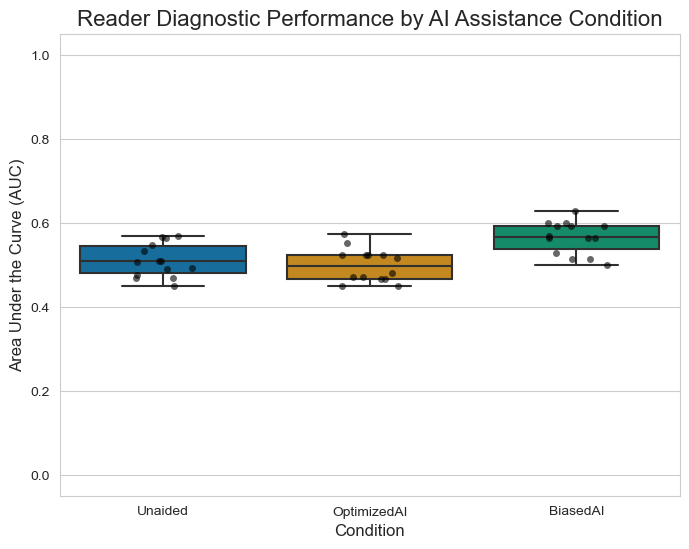


--- Secondary Analyses ---

--- Reading Time Analysis (Wilcoxon) ---
Reading Time (OptimizedAI vs. Unaided): N=14, Stat=6.000, p=0.0017
Reading Time (BiasedAI vs. Unaided): N=14, Stat=11.000, p=0.0067

--- CAM Click Analysis ---
CAM Click Percentage:
condition
Unaided          NaN
OptimizedAI    17.50
BiasedAI       14.12
Name: cam_clicked, dtype: float64

--- Analysis pipeline complete. Review outputs carefully. ---


In [12]:
# --- Part 0: Setup ---
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wilcoxon
from statsmodels.stats.contingency_tables import mcnemar
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.genmod.generalized_estimating_equations import GEE
from statsmodels.genmod.cov_struct import Exchangeable # Common correlation structure
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, confusion_matrix
import warnings # To manage convergence warnings

# --- Part 1: Data Loading and Preprocessing ---

# --- Configuration ---
file_path = "/Users/junlee/Desktop/nec_lat_result.xlsx" # <<< Your exact file path
header_row_index = 6 # Row 7 is the header (0-based index)

# --- Check if file exists ---
if not os.path.exists(file_path):
    raise FileNotFoundError(f"Error: The file was not found at {file_path}")

# --- Load the Excel file ---
xls = pd.ExcelFile(file_path)

# --- Process each sheet (each reader) ---
all_reader_data = []
print("Processing sheets (readers):")
processed_sheets = []
skipped_sheets = []
expected_rows_per_reader = 125 # Define expected count

for sheet_name in xls.sheet_names:
    print(f"- Processing sheet: {sheet_name}")
    try:
        # --- Metadata Extraction ---
        df_meta_part = pd.read_excel(xls, sheet_name=sheet_name, header=None, nrows=5)
        reader_id = "Unknown_ID"; reader_experience = "Unknown" # Defaults
        try:
            reader_id_str = str(df_meta_part.iloc[0, 0]).strip()
            reader_id = reader_id_str.split(':', 1)[1].strip() if ':' in reader_id_str else reader_id_str
            if not reader_id: reader_id = f"Reader_{sheet_name}"

            reader_title_str = str(df_meta_part.iloc[2, 0]).strip()
            reader_title = (reader_title_str.split(':', 1)[1].strip().lower() if ':' in reader_title_str else reader_title_str.lower())

            if 'specialist' in reader_title: reader_experience = 'Specialist'
            elif 'resident' in reader_title: reader_experience = 'Resident'
            else: print(f"  Warning: Unknown title '{reader_title}' in sheet {sheet_name}. Defaulting to 'Unknown'.")
        except Exception as e:
            print(f"  Error parsing metadata in sheet {sheet_name}: {e}. Skipping sheet.")
            skipped_sheets.append(sheet_name)
            continue

        # --- Read Main Data ---
        df_sheet = pd.read_excel(xls, sheet_name=sheet_name, header=header_row_index)
        df_sheet.columns = df_sheet.columns.str.strip().str.lower().str.replace(' ', '_')

        # --- Check for expected columns ---
        essential_raw_cols = ['filename', 'answer', 'show_cam', 'time', 'groundtruthbinary', 'with_ai', 'ai_model']
        optional_ai_cols = ['optimized', 'debuffed'] # Check if these exist
        actual_cols = df_sheet.columns
        missing_essential = [col for col in essential_raw_cols if col not in actual_cols]
        if missing_essential: print(f"  Warning: Missing essential data columns in sheet {sheet_name}: {missing_essential}. Skipping sheet."); skipped_sheets.append(sheet_name); continue

        rename_map = {'filename': 'case_id', 'answer': 'reader_prediction_raw', 'show_cam': 'cam_clicked',
                      'time': 'reading_time', 'groundtruthbinary': 'ground_truth_raw', 'with_ai': 'with_ai',
                      'ai_model': 'ai_model_raw'}
        for col in optional_ai_cols:
            if col in actual_cols: rename_map[col] = f'{col}_ai_pred'
        df_sheet = df_sheet.rename(columns=rename_map)

        # --- Data Cleaning & Transformation ---
        required_cols_to_process = list(rename_map.values())
        df_sheet = df_sheet[required_cols_to_process].copy()

        # Ground Truth Cleaning
        df_sheet['ground_truth'] = pd.to_numeric(df_sheet['ground_truth_raw'], errors='coerce')
        invalid_gt_count = df_sheet['ground_truth'].isnull().sum()
        if invalid_gt_count > 0: print(f"  Warning: Found {invalid_gt_count} non-numeric/missing GT values in sheet {sheet_name}. Dropping."); df_sheet.dropna(subset=['ground_truth'], inplace=True)
        if df_sheet.empty: print(f"  Sheet {sheet_name} empty after dropping invalid GT. Skipping."); skipped_sheets.append(sheet_name); continue
        df_sheet['ground_truth'] = df_sheet['ground_truth'].astype(int)

        # Reader Prediction
        df_sheet['reader_prediction'] = df_sheet['reader_prediction_raw'].apply(lambda x: 1 if str(x).strip().upper() == 'Y' else 0)

        # Condition Determination
        def determine_condition(row):
            ai_model = str(row['ai_model_raw']).strip() if pd.notna(row['ai_model_raw']) else ''
            ai_status = pd.to_numeric(row['with_ai'], errors='coerce')
            if ai_status == 0: return 'Unaided'
            elif ai_status == 1:
                if ai_model == 'OptimizedAI': return 'OptimizedAI'
                elif ai_model == 'DebuffedAI': return 'BiasedAI'
                else: return pd.NA
            else: return pd.NA
        df_sheet['condition'] = df_sheet.apply(determine_condition, axis=1)

        # Drop ambiguous conditions
        unknown_condition_count = df_sheet['condition'].isnull().sum()
        if unknown_condition_count > 0: print(f"  Warning: Found {unknown_condition_count} ambiguous AI conditions in sheet {sheet_name}. Dropping."); df_sheet.dropna(subset=['condition'], inplace=True)
        if df_sheet.empty: print(f"  Sheet {sheet_name} empty after dropping ambiguous conditions. Skipping."); skipped_sheets.append(sheet_name); continue

        # CAM Clicked Processing
        df_sheet['cam_clicked'] = df_sheet['cam_clicked'].fillna(0)
        df_sheet['cam_clicked'] = df_sheet.apply(lambda row: 0 if row['condition'] == 'Unaided' else row['cam_clicked'], axis=1)
        df_sheet['cam_clicked'] = pd.to_numeric(df_sheet['cam_clicked'], errors='coerce').fillna(0).astype(int)

        # Add Metadata
        df_sheet['reader_id'] = reader_id
        df_sheet['reader_experience'] = reader_experience

        # Final Column Selection
        final_cols = ['reader_id', 'reader_experience', 'case_id', 'ground_truth', 'condition', 'reader_prediction', 'reading_time', 'cam_clicked']
        if 'optimized_ai_pred' in df_sheet.columns: final_cols.append('optimized_ai_pred')
        if 'debuffed_ai_pred' in df_sheet.columns: final_cols.append('debuffed_ai_pred')
        df_sheet = df_sheet[final_cols]

        if len(df_sheet) != expected_rows_per_reader: print(f"  Warning: Sheet {sheet_name} has {len(df_sheet)} rows, expected {expected_rows_per_reader}.")
        all_reader_data.append(df_sheet)
        processed_sheets.append(sheet_name)

    except Exception as e: print(f"  General Error processing sheet {sheet_name}: {e}. Skipping sheet."); skipped_sheets.append(sheet_name)

# --- Combine all sheets ---
if not all_reader_data: raise ValueError("No data successfully processed. Check file path, format, and warnings.")
df_long = pd.concat(all_reader_data, ignore_index=True)

# --- Remove Duplicates ---
print("\n--- Checking for Duplicate Reads ---")
duplicates = df_long.duplicated(subset=['reader_id', 'case_id', 'condition'], keep=False)
n_duplicates = duplicates.sum()
if n_duplicates > 0: print(f"*** Warning: Found {n_duplicates} duplicate entries. Dropping... ***"); df_long = df_long.drop_duplicates(subset=['reader_id', 'case_id', 'condition'], keep='first')
else: print("No duplicate reads found.")

# --- Final Data Prep ---
df_long['is_correct'] = (df_long['ground_truth'] == df_long['reader_prediction']).astype(int)
condition_order = ['Unaided', 'OptimizedAI', 'BiasedAI']
existing_conditions = [c for c in condition_order if c in df_long['condition'].unique()]
df_long['condition'] = pd.Categorical(df_long['condition'], categories=existing_conditions, ordered=True)
df_long.dropna(subset=['condition'], inplace=True) # Final safety check

# --- Final Checks ---
print("\n--- Final Data Checks ---")
final_reader_count = df_long['reader_id'].nunique(); print(f"Successfully processed data for {final_reader_count} readers.")
if skipped_sheets: print(f"Skipped sheets: {skipped_sheets}")
if final_reader_count != 14: print(f"*** Warning: Processed data for {final_reader_count} readers, expected 14 based on previous run. ***")
print("Unique IDs:", df_long['reader_id'].unique()); print("Experience:", df_long['reader_experience'].unique()); print("Conditions:", df_long['condition'].unique())
critical_cols_check = ['reader_id', 'reader_experience', 'case_id', 'ground_truth', 'condition', 'reader_prediction', 'is_correct']
missing_data_report = df_long[critical_cols_check].isnull().sum()
if missing_data_report.sum() > 0: print("\n*** Error: Missing critical values AFTER cleaning: ***\n", missing_data_report[missing_data_report > 0]); raise ValueError("Critical missing values found.")
expected_total_rows = final_reader_count * expected_rows_per_reader; print(f"\nTotal observations: {len(df_long)} (Expected ~{expected_total_rows})")
if abs(len(df_long) - expected_total_rows) > final_reader_count * 2 : print(f"*** Warning: Row count ({len(df_long)}) significantly differs from expected ({expected_total_rows}). Check cleaning steps/warnings. ***")
print("DataFrame head:\n", df_long.head()); print("\nDataFrame info:"); df_long.info()


# --- Part 2: Performance Metrics Calculation (Table 2) ---
def calculate_metrics(data):
    gt = data['ground_truth']
    pred = data['reader_prediction']
    labels_present = gt.unique()
    auc, sens, spec = np.nan, np.nan, np.nan
    tn, fp, fn, tp = 0, 0, 0, 0
    if len(labels_present) == 2:
        try: auc = roc_auc_score(gt, pred)
        except ValueError: auc = np.nan
        cm = confusion_matrix(gt, pred, labels=[0, 1]).ravel(); tn, fp, fn, tp = cm
        sens = tp / (tp + fn) if (tp + fn) > 0 else 0; spec = tn / (tn + fp) if (tn + fp) > 0 else 0
    elif 1 in labels_present: sens = recall_score(gt, pred, pos_label=1, zero_division=0)
    elif 0 in labels_present:
        try: cm = confusion_matrix(gt, pred, labels=[0, 1]).ravel(); tn, fp, fn, tp = cm # Try getting full matrix
        except ValueError: tn = (gt==0 & pred==0).sum(); fp = (gt==0 & pred==1).sum() # Manual if only 0s
        spec = tn / (tn + fp) if (tn + fp) > 0 else 0
    acc = accuracy_score(gt, pred)
    return pd.Series({'AUC': auc, 'Accuracy': acc, 'Sensitivity': sens, 'Specificity': spec})

print("\n--- Calculating Performance Metrics (Table 2) ---")
performance_results = df_long.groupby(['reader_experience', 'condition'], observed=False).apply(calculate_metrics)
all_readers_performance = df_long.groupby('condition', observed=False).apply(calculate_metrics)
all_readers_performance.index = pd.MultiIndex.from_product([['All Readers'], all_readers_performance.index.categories], names=['reader_experience', 'condition'])
final_performance_table = pd.concat([all_readers_performance, performance_results]).dropna(how='all')
print("\n--- Manuscript Table 2: Performance Metrics ---")
print(final_performance_table.round(3))
final_performance_table.to_csv('manuscript_table_2_performance.csv'); print("\nPerformance table saved.")


# --- Part 2b: Analyze Raw AI Predictions Shown to Readers ---
print("\n--- Analyzing Standalone Performance of AI Predictions Shown ---")
# --- Optimized AI Predictions Analysis ---
opt_ai_cases = df_long[df_long['condition'] == 'OptimizedAI'].copy()
if 'optimized_ai_pred' in opt_ai_cases.columns and not opt_ai_cases.empty:
    opt_ai_cases.dropna(subset=['optimized_ai_pred'], inplace=True)
    opt_ai_cases['optimized_ai_pred'] = opt_ai_cases['optimized_ai_pred'].astype(int)
    print("\nPerformance of OptimizedAI Predictions (on cases where it was shown):")
    gt_opt = opt_ai_cases['ground_truth']; pred_opt = opt_ai_cases['optimized_ai_pred']
    if len(gt_opt.unique()) > 1:
        auc_opt_ai = roc_auc_score(gt_opt, pred_opt); tn, fp, fn, tp = confusion_matrix(gt_opt, pred_opt, labels=[0,1]).ravel()
        sens_opt_ai = tp / (tp + fn) if (tp + fn) > 0 else 0; spec_opt_ai = tn / (tn + fp) if (tn + fp) > 0 else 0
    else: auc_opt_ai, sens_opt_ai, spec_opt_ai = np.nan, np.nan, np.nan # Simplified handling
    acc_opt_ai = accuracy_score(gt_opt, pred_opt)
    print(f"  AUC: {auc_opt_ai:.3f}, Acc: {acc_opt_ai:.3f}, Sens: {sens_opt_ai:.3f}, Spec: {spec_opt_ai:.3f}")
else: print("Optimized AI prediction column not found or no OptimizedAI cases.")

# --- Underlying Flawed (Debuffed) AI Predictions Analysis ---
bias_ai_cases = df_long[df_long['condition'] == 'BiasedAI'].copy()
if 'debuffed_ai_pred' in bias_ai_cases.columns and not bias_ai_cases.empty:
    bias_ai_cases.dropna(subset=['debuffed_ai_pred'], inplace=True)
    bias_ai_cases['debuffed_ai_pred'] = bias_ai_cases['debuffed_ai_pred'].astype(int)
    print("\nPerformance of Underlying Flawed ('Debuffed') AI Predictions (on cases shown as BiasedAI):")
    gt_deb = bias_ai_cases['ground_truth']; pred_deb = bias_ai_cases['debuffed_ai_pred']
    if len(gt_deb.unique()) > 1:
        auc_deb_ai = roc_auc_score(gt_deb, pred_deb); tn, fp, fn, tp = confusion_matrix(gt_deb, pred_deb, labels=[0,1]).ravel()
        sens_deb_ai = tp / (tp + fn) if (tp + fn) > 0 else 0; spec_deb_ai = tn / (tn + fp) if (tn + fp) > 0 else 0
    else: auc_deb_ai, sens_deb_ai, spec_deb_ai = np.nan, np.nan, np.nan
    acc_deb_ai = accuracy_score(gt_deb, pred_deb)
    print(f"  AUC: {auc_deb_ai:.3f}, Acc: {acc_deb_ai:.3f}, Sens: {sens_deb_ai:.3f}, Spec: {spec_deb_ai:.3f}")
    print("\nCompare this 'Debuffed AI Performance' to the final 'BiasedAI Tool Performance' (Acc=0.45, Sens=0.40, Spec=0.47) to see sabotage effect.")
else: print("Debuffed AI prediction column not found or no BiasedAI cases.")


# --- Part 3: Hypothesis Testing ---
print("\n--- Hypothesis Testing ---")
print("\n--- Calculating Per-Reader Metrics ---")
per_reader_metrics = df_long.groupby(['reader_id', 'condition'], observed=False).apply(calculate_metrics)
per_reader_auc = per_reader_metrics['AUC'].unstack(fill_value=np.nan)
per_reader_acc = per_reader_metrics['Accuracy'].unstack(fill_value=np.nan)
per_reader_sens = per_reader_metrics['Sensitivity'].unstack(fill_value=np.nan)
per_reader_spec = per_reader_metrics['Specificity'].unstack(fill_value=np.nan)
print("Per-Reader AUCs (head):\n", per_reader_auc.head().round(3))
print("Per-Reader Accuracy (head):\n", per_reader_acc.head().round(3))

print("\n--- Wilcoxon Signed-Rank Tests (Paired Comparisons) ---")
def run_wilcoxon(metric_df, cond1, cond2, metric_name):
    if cond1 not in metric_df.columns or cond2 not in metric_df.columns: print(f"Skipping {metric_name}: Cols missing."); return
    paired_data = metric_df[[cond1, cond2]].dropna()
    if len(paired_data) >= 6:
        diffs = paired_data[cond2] - paired_data[cond1]
        if np.all(diffs == 0): print(f"{metric_name} ({cond2} vs. {cond1}): N={len(paired_data)}, No diff (p=1.0)."); return
        try: stat, p_val = wilcoxon(paired_data[cond2], paired_data[cond1], zero_method='zsplit', correction=True); print(f"{metric_name} ({cond2} vs. {cond1}): N={len(paired_data)}, Stat={stat:.3f}, p={p_val:.4f}")
        except ValueError as e: print(f"Wilcoxon Error {metric_name}: {e}")
    else: print(f"Not enough pairs ({len(paired_data)}) for {metric_name} ({cond2} vs. {cond1}).")

run_wilcoxon(per_reader_auc, 'Unaided', 'OptimizedAI', 'AUC')
run_wilcoxon(per_reader_auc, 'Unaided', 'BiasedAI', 'AUC')
run_wilcoxon(per_reader_acc, 'Unaided', 'OptimizedAI', 'Accuracy')
run_wilcoxon(per_reader_acc, 'Unaided', 'BiasedAI', 'Accuracy')
run_wilcoxon(per_reader_sens, 'Unaided', 'OptimizedAI', 'Sensitivity')
run_wilcoxon(per_reader_sens, 'Unaided', 'BiasedAI', 'Sensitivity')
run_wilcoxon(per_reader_spec, 'Unaided', 'OptimizedAI', 'Specificity')
run_wilcoxon(per_reader_spec, 'Unaided', 'BiasedAI', 'Specificity')

# --- McNemar REMOVED ---

# --- GEE ---
print("\n--- GEE for Interaction Effect (Condition * Experience) ---")
df_gee = df_long.dropna(subset=['condition', 'reader_experience', 'is_correct', 'reader_id'])
df_gee = df_gee[df_gee['reader_experience'] != 'Unknown'].copy()
df_gee['condition'] = df_gee['condition'].astype(str); df_gee['reader_experience'] = df_gee['reader_experience'].astype(str)
df_gee['is_correct'] = df_gee['is_correct'].astype(float)
if df_gee['reader_experience'].nunique() < 2: print("Warning: Only one experience level. Interaction cannot be estimated.")
else:
    formula = "is_correct ~ C(condition, Treatment('Unaided')) * C(reader_experience, Treatment('Specialist'))"
    if not df_gee.empty:
        try:
            print("Fitting GEE model..."); fam = sm.families.Binomial(); cs = Exchangeable()
            with warnings.catch_warnings(): warnings.simplefilter("ignore"); gee = smf.gee(formula, groups=df_gee["reader_id"], data=df_gee, family=fam, cov_struct=cs); result_gee = gee.fit(cov_type='robust')
            print(result_gee.summary())
            if not result_gee.converged: print("\n*** Warning: GEE did not converge. ***")
            print("\nCheck p-value ('P>|z|') for interaction terms.")
        except Exception as e_gee: print(f"Error fitting GEE: {e_gee}.")
    else: print("GEE could not run: DataFrame empty.")

# --- Part 4: Plotting (Figure 3 - AUC Boxplot) ---
print("\n--- Generating Figure 3: AUC Box Plot ---")
per_reader_auc_melted = per_reader_auc.reset_index().melt(id_vars='reader_id', value_vars=existing_conditions, var_name='condition', value_name='AUC').dropna()
per_reader_auc_melted['condition'] = pd.Categorical(per_reader_auc_melted['condition'], categories=existing_conditions, ordered=True)
plt.figure(figsize=(8, 6)); sns.set_style("whitegrid")
ax = sns.boxplot(x='condition', y='AUC', data=per_reader_auc_melted, order=existing_conditions, palette="colorblind", showfliers=False)
sns.stripplot(x='condition', y='AUC', data=per_reader_auc_melted, order=existing_conditions, color='black', alpha=0.6, jitter=0.15, ax=ax)
ax.set_title('Reader Diagnostic Performance by AI Assistance Condition', fontsize=16); ax.set_xlabel('Condition', fontsize=12); ax.set_ylabel('Area Under the Curve (AUC)', fontsize=12); ax.set_ylim(-0.05, 1.05)
plt.savefig('manuscript_figure_3_auc_boxplot.png', dpi=300, bbox_inches='tight'); plt.savefig('manuscript_figure_3_auc_boxplot.pdf', bbox_inches='tight'); print("Box plot saved."); plt.show()

# --- Part 5: Secondary Analyses ---
print("\n--- Secondary Analyses ---")
print("\n--- Reading Time Analysis (Wilcoxon) ---")
per_reader_time = df_long.groupby(['reader_id', 'condition'], observed=False)['reading_time'].mean().unstack(fill_value=np.nan)
run_wilcoxon(per_reader_time, 'Unaided', 'OptimizedAI', 'Reading Time')
run_wilcoxon(per_reader_time, 'Unaided', 'BiasedAI', 'Reading Time')

print("\n--- CAM Click Analysis ---")
cam_clicks = df_long[df_long['condition'].isin(['OptimizedAI', 'BiasedAI'])]
if not cam_clicks.empty and 'condition' in cam_clicks.columns:
    click_percentage = cam_clicks.groupby('condition', observed=False)['cam_clicked'].mean() * 100
    print("CAM Click Percentage:")
    print(click_percentage.round(2))
else: print("No data for CAM click analysis.")

print("\n--- Analysis pipeline complete. Review outputs carefully. ---")